In [1]:
import os 
import numpy as np
from util import plot_figure
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
color_list = sns.color_palette()
from util import compute_spectral_gap

### Check Details

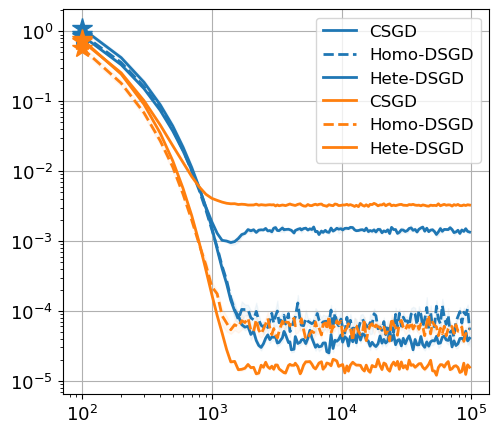

In [2]:
num_agent_list = [10, 20, ]
# 20, 30, 40, 50
fig, ax = plt.subplots(figsize=(5.5, 5))

for idx, num_agent in enumerate(num_agent_list):

    plot_csgd = plot_figure(algo_name=f'csgd', sub_sample=5, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=True, metric='mse')
    plot_csgd.plot_lines(ax, color_list[idx], label='CSGD', legend=True, plot_star=True)
    
    plot_csgd = plot_figure(algo_name=f'dsgd-homo', sub_sample=5, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=True, metric='wmse')
    plot_csgd.plot_lines(ax, color_list[idx], label='Homo-DSGD', legend=True, plot_star=True, line='--')

    plot_csgd = plot_figure(algo_name=f'dsgd-hete', sub_sample=5, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=True, metric='wmse')
    plot_csgd.plot_lines(ax, color_list[idx], label='Hete-DSGD', legend=True, plot_star=True)

plt.grid(True)

## Compute Transient time

In [3]:
def load_data(dir, word):
    file = [f for f in os.listdir(dir) if word in f]
    files = [np.load(os.path.join(dir, f), allow_pickle=True) for f in file]
    res = np.array([f.item().get('wmse') for f in files])
    xvals = files[0].item().get('iter')
    mean_res = np.mean(res, axis=0)
    return xvals, mean_res

def find_window(data, window_size, threshold):
    start_index = 0
    while start_index + window_size <= len(data):
        window = data[start_index:start_index+window_size]
        count = np.sum(window < threshold)
        if count >= window_size * 0.8:
            return start_index + window_size - 1
        start_index += 1
    return None


num_agent_list = [10, 20, 30, 40]
xvals = []
tran_time_list = []
graph = 'RingGraph'
window_size = 10

for num_agent in num_agent_list:

    # Get sqrt(n)/rho
    file_name = f's2_data/NumAgent{num_agent}/' + f'MixingMat-{graph}-NumAgent{num_agent}.npy'
    W = np.load(file_name)
    spectral_gap = compute_spectral_gap(W)
    xvals.append(np.sqrt(num_agent)/spectral_gap)

    # Get tran time
    parent_path = f'./s2_res/NumAgent{num_agent}'
    x_csgd, y_csgd = load_data(parent_path, 'csgd')
    keyword_dsgd = f'dsgd-homo-RingGraph'
    _, y_dsgd = load_data(parent_path, keyword_dsgd)

    ratio = y_csgd / y_dsgd
    index = find_window(ratio, window_size, 0.5)
    if index is None:
        raise ValueError(f'Num Agent:{num_agent} No transient time found')
    tran_time = x_csgd[index]
    tran_time_list.append(tran_time)

Text(0, 0.5, '$T_{cvx}$')

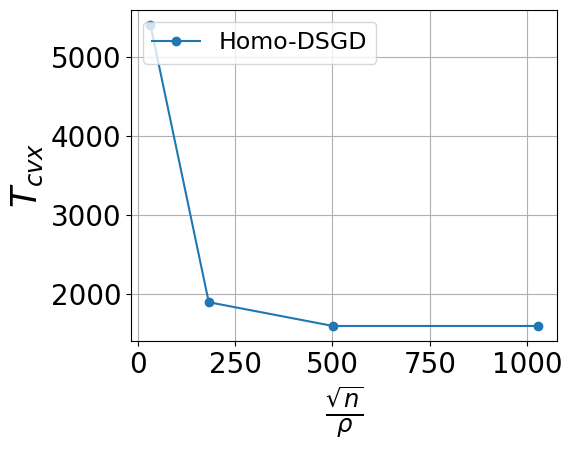

In [4]:
fig, ax = plt.subplots(figsize=(5.5,4.3))  # 设置图片大小为 8x6

plt.plot(xvals, tran_time_list, label=r'Homo-DSGD', color=color_list[0], marker='o', markersize=6, linestyle='-')
# plt.xscale('log')
# plt.yscale('log')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.legend(loc=2, prop={'size': 17})
plt.grid()
plt.xlabel(r'$\frac{\sqrt{n}}{\rho}$', fontsize = 25)
plt.ylabel(r'$T_{cvx}$', fontsize = 25)

In [48]:
xvals

[33.11580158474131, 182.74694061292294, 501.29283364558853, 1027.4090782333064]

In [49]:
tran_time_list

[5400, 1900, 1600, 1600]